In [1]:
from sympy import symbols, solve, lambdify, sympify, dsolve, Eq, solveset, linear_eq_to_matrix, nonlinsolve, Matrix, diff, sqrt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import quiver
from scipy import integrate

from ipywidgets import widgets
from IPython.display import clear_output, display

In [47]:
def rk4( f, x0, y0, h, xn ):
    n = int((xn - x0)/h)
    x = np.array( [ x0 ] * n, dtype=float )
    y = np.array( [ y0 ] * n, dtype=float )
    for i in range( n-1 ):
        k1 = h * f( x[i], y[i] )
        k2 = h * f( x[i] + 0.5 * h, y[i] + 0.5 * k1 )
        k3 = h * f( x[i] + 0.5 * h, y[i] + 0.5 * k2 )
        k4 = h * f( x[i] + h, y[i] + k3 )
        
        x[i+1] = x[i] + h
        y[i+1] = y[i] + ( k1 + 2.0 * ( k2 + k3 ) + k4 ) / 6.0
        
    return y, x


In [75]:
def plotEquation (eq, solvar, plotvar, inputrange):
    '''
        Given a sympy equation object `eq`, this function return a series of values,
        in the range of `inputrange` such that the equation is solved for
        `solvar` and the input is for `plotvar`
    '''
    eq = Eq(eq, 0)
    sol = solve(eq, solvar)
    vals = []
    for s in sol:
        f = lambdify((plotvar), sol)
        vals.append([f(i) for i in inputrange])

    return vals

In [7]:
def findFixedPoints(f, g, xrange, yrange):
    return [(x, y) for x in xrange for y in yrange if f(x, y) == 0 and g(x, y) == 0]

In [8]:
def eigenvalues(expr1, expr2):
    a11 = diff(expr1, x)
    a12 = diff(expr1, y)
    
    a21 = diff(expr2, x)
    a22 = diff(expr2, y)
    
    tr = a11 + a22
    det = a11*a22 - a12*a21
    lambda1 = (tr - sqrt(tr**2 - 4*det))/2
    lambda2 = (tr + sqrt(tr**2 - 4*det))/2
    
#     print(lambda1)
#     print(lambda2)
    
#     print('Check the fixed point  %s, %s' % (x,y))
#     print('The real part of the first eigenvalue is %s' % lambda1.real)
#     print('The real part of the second eigenvalue is %s' % lambda2.real)    
    
#     if (lambda1.real < 0 and lambda2.real < 0):
#         print('The fixed point in %s, %s is a sink. It is stable' % (x,y))
#     if (lambda1.real > 0 and lambda2.real > 0):
#         print('The fixed point in %s, %s is a source. It is unstable' % (x,y))
#     if (lambda1.real > 0 and lambda2.real < 0):
#         print('The fixed point in %s, %s is a saddle. It is unstable' % (x,y))
#     if (lambda1.real < 0 and lambda2.real > 0):
#         print('The fixed point in %s, %s is unstable' % (x,y))
    return lambda1 , lambda2

In [61]:
def system(initialx, initialy, func1, func2, delta, timerange):
    x = [initialx]
    y = [initialy]
    
    for i in range(timerange):
        x.append(x[i] + func1(x[i], y[i]) * delta)
        y.append(y[i] + func2(x[i], y[i]) * delta)
    
    return x, y

In [84]:
def on_change():
    clear_output()
    
    # converting the equations to functions
    f1 = lambdify((x, y), expr1)
    f2 = lambdify((x, y), expr2)
    
    # phase space
    sx, sy = system(10, 2, f1, f2, 0.01, 1000)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
    ax1.plot(sx, label='X in Time')
    ax1.plot(sy, label='Y in Time')
    ax2.plot(sx, sy, label='X against Y')
    ax1.legend()
    ax2.legend()
    
    # compute ranges to work in
    yrange = np.linspace(y_range_slider.value[0], y_range_slider.value[1])
    xrange = np.linspace(x_range_slider.value[0], x_range_slider.value[1])
    
    # a plot for the quiver plot and nullclines
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xlim([min(xrange), max(xrange)])
    ax.set_ylim([min(yrange), max(yrange)])
    
    # plotting the 4 nullclines from range-kutta4
    rkx, rky = rk4( f1, min(xrange), -1000, .25, max(xrange) )
    ax.scatter(rkx, rky, marker='+', label='Solution with Runge-Kutta 4', s=150)
    
    rky, rkx = rk4( f1, min(xrange), -1000, .25, max(xrange) )
    ax.scatter(rkx, rky, marker='+', label='Solution with Runge-Kutta 4', s=150)
    
    rkx, rky = rk4( f2, min(yrange), 0, .25, max(yrange) )
    ax.scatter(rkx, rky, marker='+', label='Solution with Runge-Kutta 4', s=150)
    
    rky, rkx = rk4( f2, min(yrange), 0, .25, max(yrange) )
    ax.scatter(rkx, rky, marker='+', label='Solution with Runge-Kutta 4', s=150)
    
    # compute quivers
    f1_val = [[f1(i, j) for i in xrange] for j in yrange];
    f2_val = [[f2(i, j) for i in xrange] for j in yrange];

    # plot quiver plot
    q = ax.quiver(xrange, yrange, f1_val, f2_val, alpha=.5)
    
    # solve analytically using sympy
    solutions = nonlinsolve([expr1, expr2], x, y)
    
    # compute jacobian and eigen values
    equationMatrix = Matrix([ expr1, expr2 ])
    varMat = Matrix([ x, y ])
    jacobian = equationMatrix.jacobian(varMat)
    display('Jacobian Matrix')
    display(jacobian)
    
    # display eigen values
    for s in solutions:
        eqmat = jacobian.subs([ (x, s[0]), (y, s[1]) ])
        display('Eigen Values for %s' % s)
        display(eqmat)
    
    # plot the analytical solution
    try:
        [ax.plot(yrange, nc, c='b', alpha=.7, label='Analytical Solution') for nc in plotEquation(expr1, y, x, yrange)]
        [ax.plot(nc, yrange, c='b', alpha=.7, label='Analytical Solution') for nc in plotEquation(expr1, x, y, xrange)]
        [ax.plot(nc, xrange, c='r', alpha=.7, label='Analytical Solution') for nc in plotEquation(expr2, x, y, xrange)]
        [ax.plot(xrange, nc, c='r', alpha=.7, label='Analytical Solution') for nc in plotEquation(expr2, y, x, yrange)]
    except:
        print('Some nullcline values are complex')
    
    # plot the roots
    try:
        [ax.scatter(i[0], i[1], marker='x', label='Stable Point', s=150) for i in solutions]
    except:
        print('Some roots are complex')

    # a legend for our plot
    fig.legend(framealpha=1, fancybox=True, fontsize='large', loc=1)
    fig.show()


# Specify your equation

In [83]:
x, y = symbols('x y')

# expr1 = 2*x - y + 3*(x**2 - y**2) + 2*x*y
expr1 = 2*x - x**2 - x*y
display(expr1)

# expr2 = x - 3*y - 3*(x**2-y**2) + 3*x*y
expr2 = -y + x*y
display(expr2)

-x**2 - x*y + 2*x

x*y - y

# Select range of x and y values and click the plot button

'Jacobian Matrix'

Matrix([
[-2*x - y + 2,    -x],
[           y, x - 1]])

'Eigen Values for (0, 0)'

Matrix([
[2,  0],
[0, -1]])

'Eigen Values for (1, 1)'

Matrix([
[-1, -1],
[ 1,  0]])

'Eigen Values for (2, 0)'

Matrix([
[-2, -2],
[ 0,  1]])

<ipython-input-84-8173e74e69e1>:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


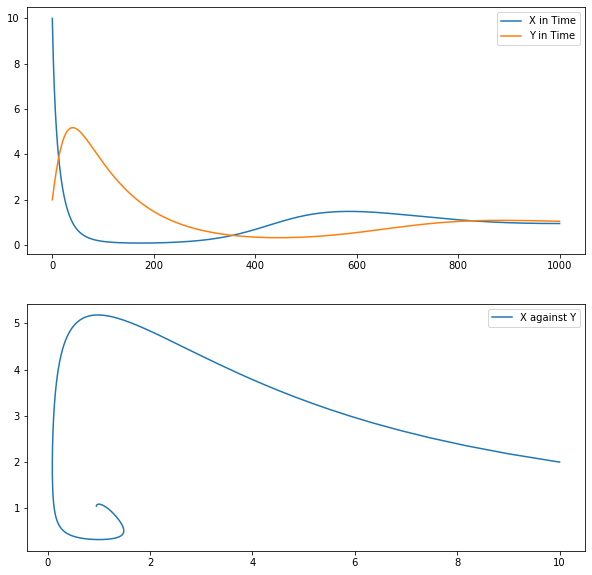

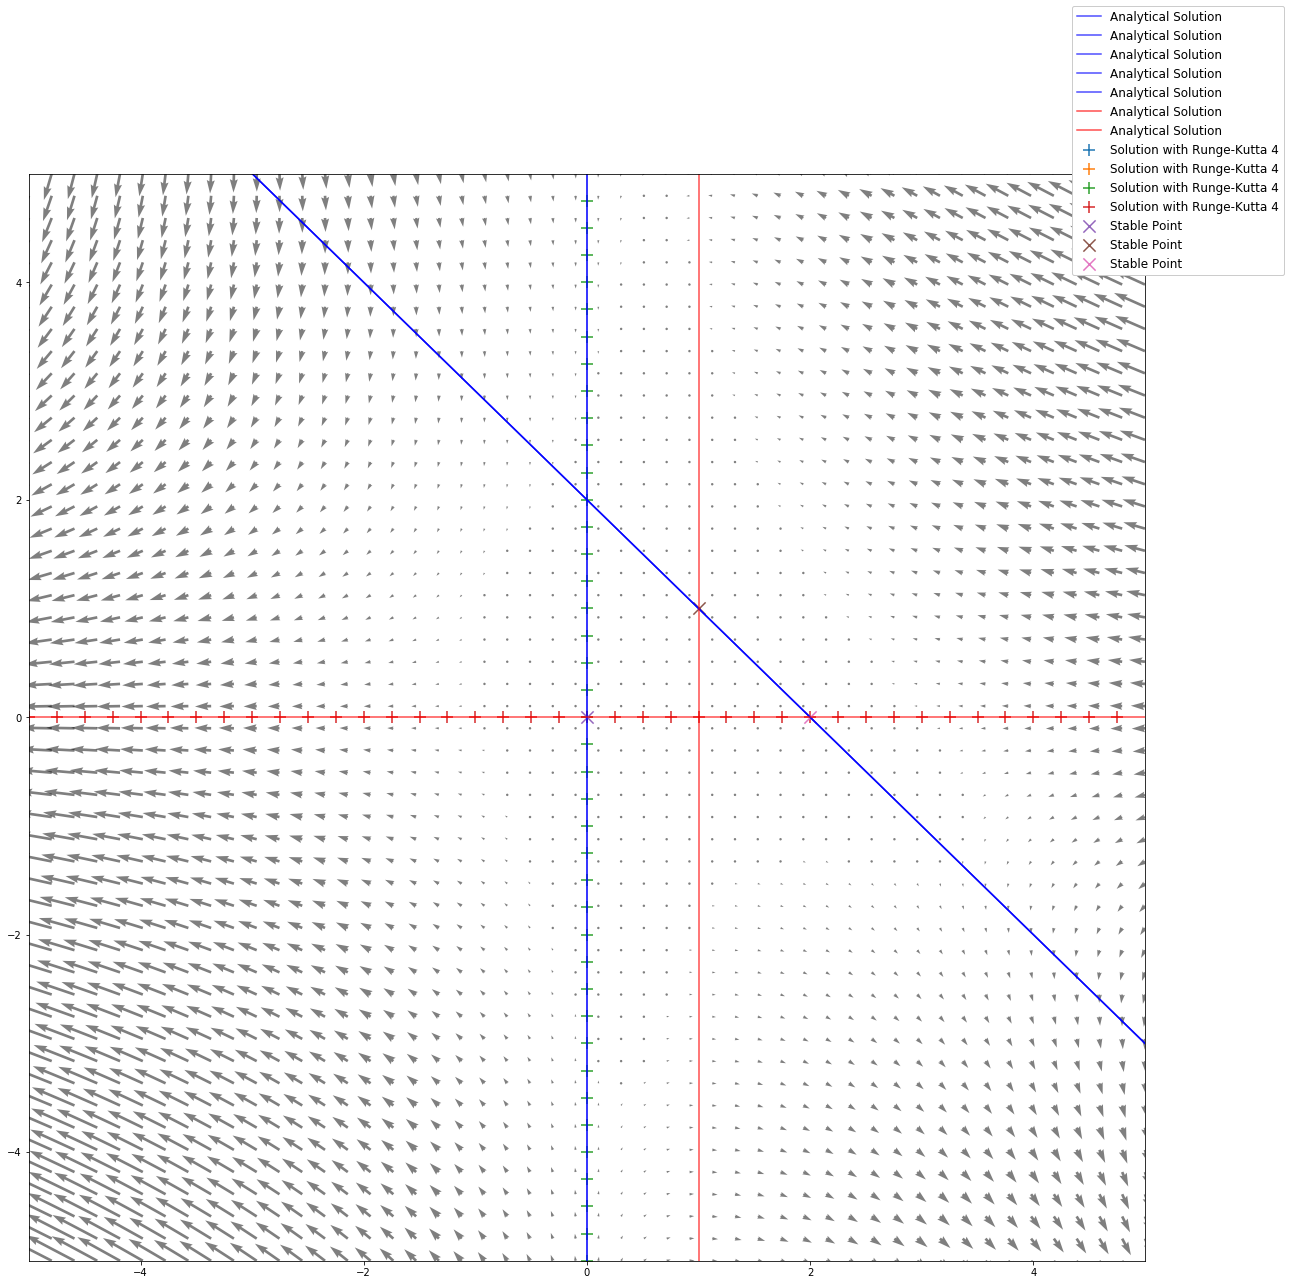

In [39]:
y_range_slider = widgets.IntRangeSlider(min=-10, max=10)
display(y_range_slider)

x_range_slider = widgets.IntRangeSlider(min=-10, max=10)
display(x_range_slider)

# y_range_slider.observe(on_change)
# x_range_slider.observe(on_change)

renderButton = widgets.Button(description='Plot')
display(renderButton)

@renderButton.on_click
def renderButtonOnClick(b):
    on_change()
